In [1]:
# Recurrent Neural Network Jam

In [2]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rc('legend', fontsize=18)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.constrained_layout.use'] = True
fs = (10, 6)

/opt/anaconda3/envs/aml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [126]:
# Convert an array of values into a dataset matrix:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [127]:
np.random.seed(69)

# Load data
col = [12]
file = read_csv('./Data/station_6190.csv', usecols=col,  engine='python')  # 10 pressure 12 temp
# dataset = file[:100]
dataset = file
dataset = dataset.values
dataset = dataset.astype('float32')

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split data
trainsize = int(len(dataset) * 0.67)
testsize = len(dataset) - trainsize
train, test = dataset[0:trainsize,:], dataset[trainsize:len(dataset),:]

# Reshape
lookback = 5
trainx, trainy = create_dataset(train, lookback)
testx,  testy  = create_dataset(test,  lookback)

# Reshape again
trainx = np.reshape(trainx, (trainx.shape[0], trainx.shape[1], 1))
testx  = np.reshape(testx,  (testx.shape[0],  testx.shape[1],  1))

In [128]:
trainx.shape, trainy.shape

((66691, 5, 1), (66691,))

In [129]:
# Create pytorch tensors
trainx = torch.tensor(trainx, dtype=torch.float)
trainy = torch.tensor(trainy, dtype=torch.float)

testx  = torch.tensor(testx, dtype=torch.float)
testy  = torch.tensor(testy, dtype=torch.float)

In [130]:
class Net(nn.Module):
    def __init__(self, hidden_size=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x


net = Net()

In [131]:
opt = torch.optim.Adam(net.parameters(), lr=5e-3)
progress_bar = tqdm(range(1000))

for epoch in progress_bar:
    prediction = net(trainx)
    loss = torch.sum((prediction.flatten() - trainy.flatten())**2)
    progress_bar.set_description('Loss = {}'.format(float(loss)))
    loss.backward()
    opt.step()
    opt.zero_grad()

Loss = 14.174234390258789: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


Train Score: 0.63 RMSE
Test Score: 0.62 RMSE


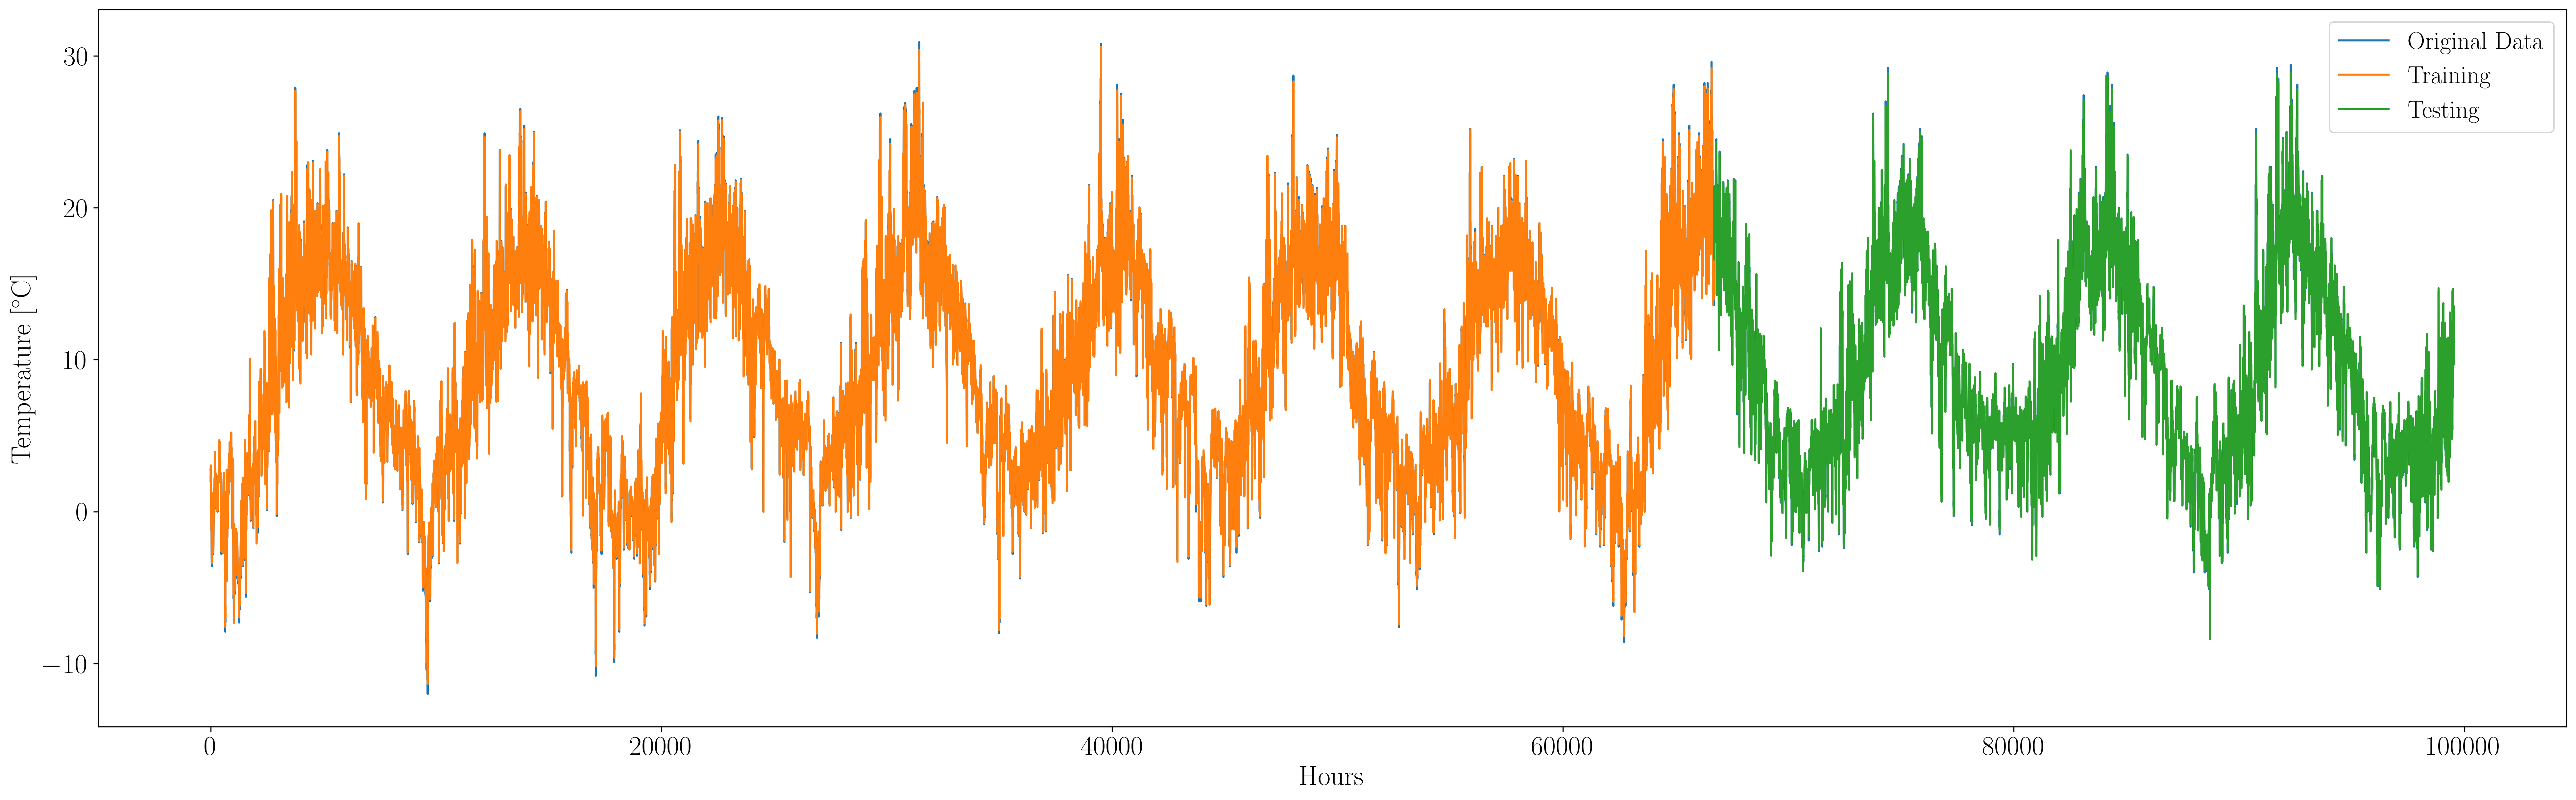

In [148]:
# make predictions
with torch.no_grad():
    trainPredict = net(trainx).numpy()
    testPredict = net(testx).numpy()

look_back = lookback


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainy_inv = scaler.inverse_transform([trainy.numpy()])
testPredict = scaler.inverse_transform(testPredict)
testy_inv = scaler.inverse_transform([testy.numpy()])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainy_inv[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testy_inv[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(26,8))
plt.plot(scaler.inverse_transform(dataset), label=r'Original Data')
plt.plot(trainPredictPlot, label=r'Training')
plt.plot(testPredictPlot, label=r'Testing')
if col == [12]:
    plt.ylabel(r'Temperature [$^{\circ}$C]')
elif col == [10]:
    plt.ylabel(r'Pressure [idk]')
else:
    print('error')
plt.xlabel(r'Hours')
# plt.xlim([60000, 80000])
plt.legend()
plt.show()

#### __Predict Using Model__

In [145]:
# testing
example = np.array([12.2, 12.4, 12.4, 12.5, 12.5])
example = np.reshape(example, (5, 1))
example = scaler.transform(example)
example = np.reshape(example, (1, 5, 1))
example = torch.tensor(example, dtype=torch.float)
# make predictions
with torch.no_grad():
    predict = net(example).numpy()

predict = scaler.inverse_transform(predict)
# score 
print(np.float16(predict))

[[12.51]]


## __Better Model Hopefully__

In [53]:
# ta/station_6190.csv', usecols=np.arange(7, 17), engine='python')
# file = np.array(file)
# # file = np.reshape(file, (file.shape[0], file.shape[1], 1))
# print(file.shape)
# scaler = MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(file)file = read_csv('./Da

file = pd.read_csv('./Data/station_6190.csv')
time = file['hour']
file = file.drop(['year', 'month', 'day', 'hour', 'stationId', 'latitude', 'longitude', 'min_temp', 'max_temp_w_date'], axis=1)
# file = file.head()
data = file.copy()

scaler = MinMaxScaler(feature_range=(0, 1))

scalers = []

realscale = MinMaxScaler(feature_range=(0, 1)).fit(np.array(file['mean_temp']).reshape(-1, 1))

for i in range(len(file.columns)):
    scaler.fit(np.array(file[file.columns[i]]).reshape(-1, 1))
    scalers.append(scaler)
    data[data.columns[i]] = scaler.transform(np.array(file[file.columns[i]]).reshape(-1, 1))

# data = scaler.fit_transform(file)
# data = np.array(file)
# data = file.copy()

In [4]:
# data = data.head(10000)
data.head()

,max_wind_speed_10min,max_wind_speed_3sec,mean_pressure,mean_relative_hum,mean_temp,mean_wind_dir,mean_wind_speed,vapour_pressure_deficit_mean
0,0.746606,0.707463,0.461632,0.972,0.326340,0.697222,0.719626,0.0
1,0.791855,0.707463,0.433618,0.968,0.333333,0.702778,0.799065,0.0
2,0.791855,0.692537,0.410475,0.978,0.335664,0.705556,0.799065,0.0
3,0.769231,0.677612,0.397077,0.968,0.342657,0.719444,0.785047,0.0
4,0.837104,0.737313,0.389769,0.958,0.347319,0.750000,0.742991,0.0


In [5]:
sequence_length  = 50
forecast_horizon = 5

series_x = []
series_y = []

for t in range(sequence_length, (len(data)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
    series_x.append(np.array(data[data.columns][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
    series_y.append(data['mean_temp'][t+forecast_horizon])# here we select the observed measurement at t+forecast_horizon in the future

# for t in range(sequence_length,(len(data)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
#     series_x.append(np.array(data[['mean_temp', 'mean_pressure']][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
#     series_y.append(data['mean_temp'][t+forecast_horizon])# here we select the observed measurement at t+forecast_horizon in the future

series_x = np.array(series_x)
series_y = np.array(series_y)

print('dimensions of input:')
print(series_x.shape)
print('-------------')
print('dimension of truth:')
print(series_y.shape)
print('-------------')
print('total number of time steps in data:')
print((len(data)))

dimensions of input:
(99493, 50, 8)
-------------
dimension of truth:
(99493,)
-------------
total number of time steps in data:
99548


In [6]:
xtrain, xvalid, ytrain, yvalid = train_test_split(series_x, series_y, test_size=0.3, random_state=69)

In [7]:
xvalid.shape

(29848, 50, 8)

In [8]:
tsinputs = tf.keras.Input(shape=(sequence_length, len(file.columns)))

x = layers.LSTM(units=10)(tsinputs)
x = layers.Dropout(0.01)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=tsinputs, outputs=outputs)

2022-06-13 22:53:47.523343: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
learningrate = 1e-3
nepochs = 15
batchsize = 50
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=learningrate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse'])
history = model.fit(x=xtrain, y=ytrain, batch_size=batchsize, validation_data=(xvalid, yvalid), epochs=nepochs)

Epoch 1/15
1393/1393 [==============================] - 19s 13ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 2/15
1393/1393 [==============================] - 16s 12ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 3/15
1393/1393 [==============================] - 15s 11ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/15
1393/1393 [==============================] - 16s 11ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 5/15
1393/1393 [==============================] - 16s 11ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/15
1393/1393 [==============================] - 18s 13ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/15
1393/1393 [==============================] - 17s 12ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/15
1393/1393 [==========================

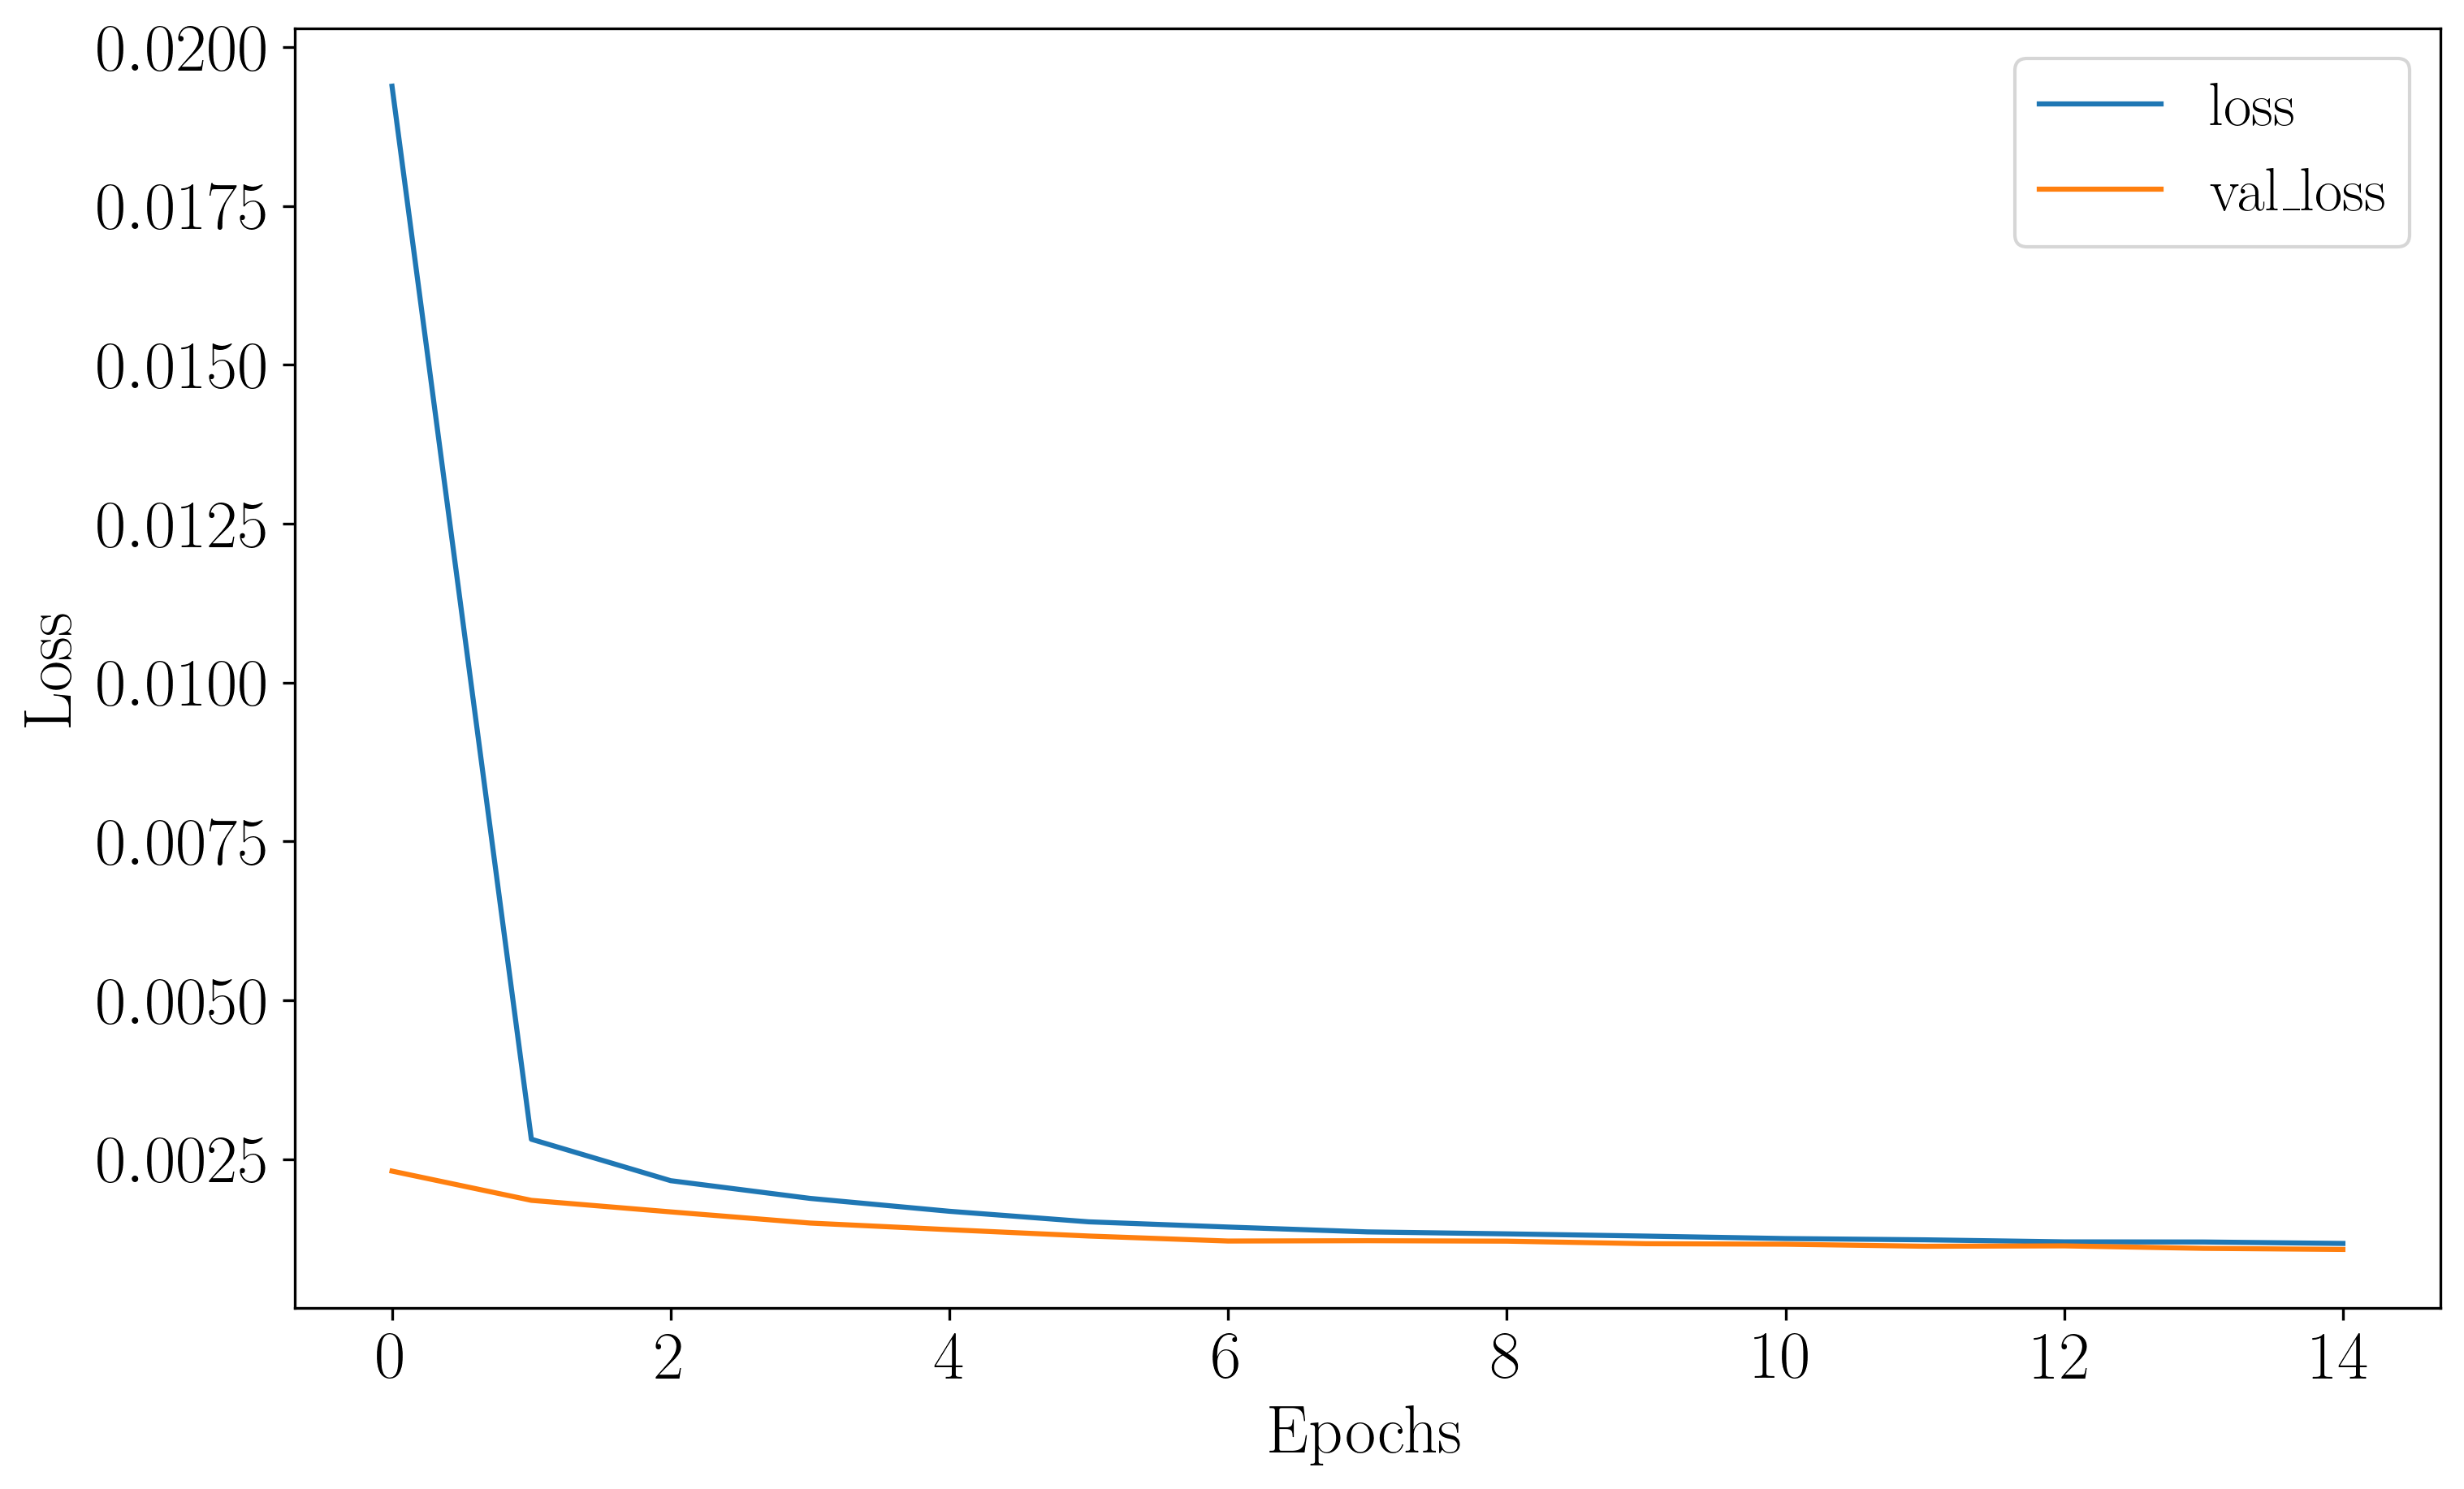

In [10]:
loss = history.history['loss']
valloss = history.history['val_loss']
epochs = np.arange(len(loss))

plt.figure(figsize=fs)
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, valloss, label='val_loss')
plt.xlabel(r'Epochs')
plt.ylabel(r'Loss')
plt.legend()
plt.show()

In [54]:
predictions = model.predict(x=xvalid)

pred = scalers[4].inverse_transform(predictions)
predr = realscale.inverse_transform(predictions)
yinv = scalers[4].inverse_transform(yvalid.reshape(-1, 1))
yinvr = realscale.inverse_transform(yvalid.reshape(-1, 1))

tpred = model.predict(x=xtrain)
tpred = scalers[4].inverse_transform(tpred)
tyinv = scalers[4].inverse_transform(ytrain.reshape(-1, 1))

In [55]:
predictions.shape, yvalid.shape

((29848, 1), (29848,))

In [56]:
traintime, testtime = train_test_split(time, test_size=0.3)

Train Score: 0.091936 RMSE
Test  Score: 0.091869 RMSE
6.276689858911383


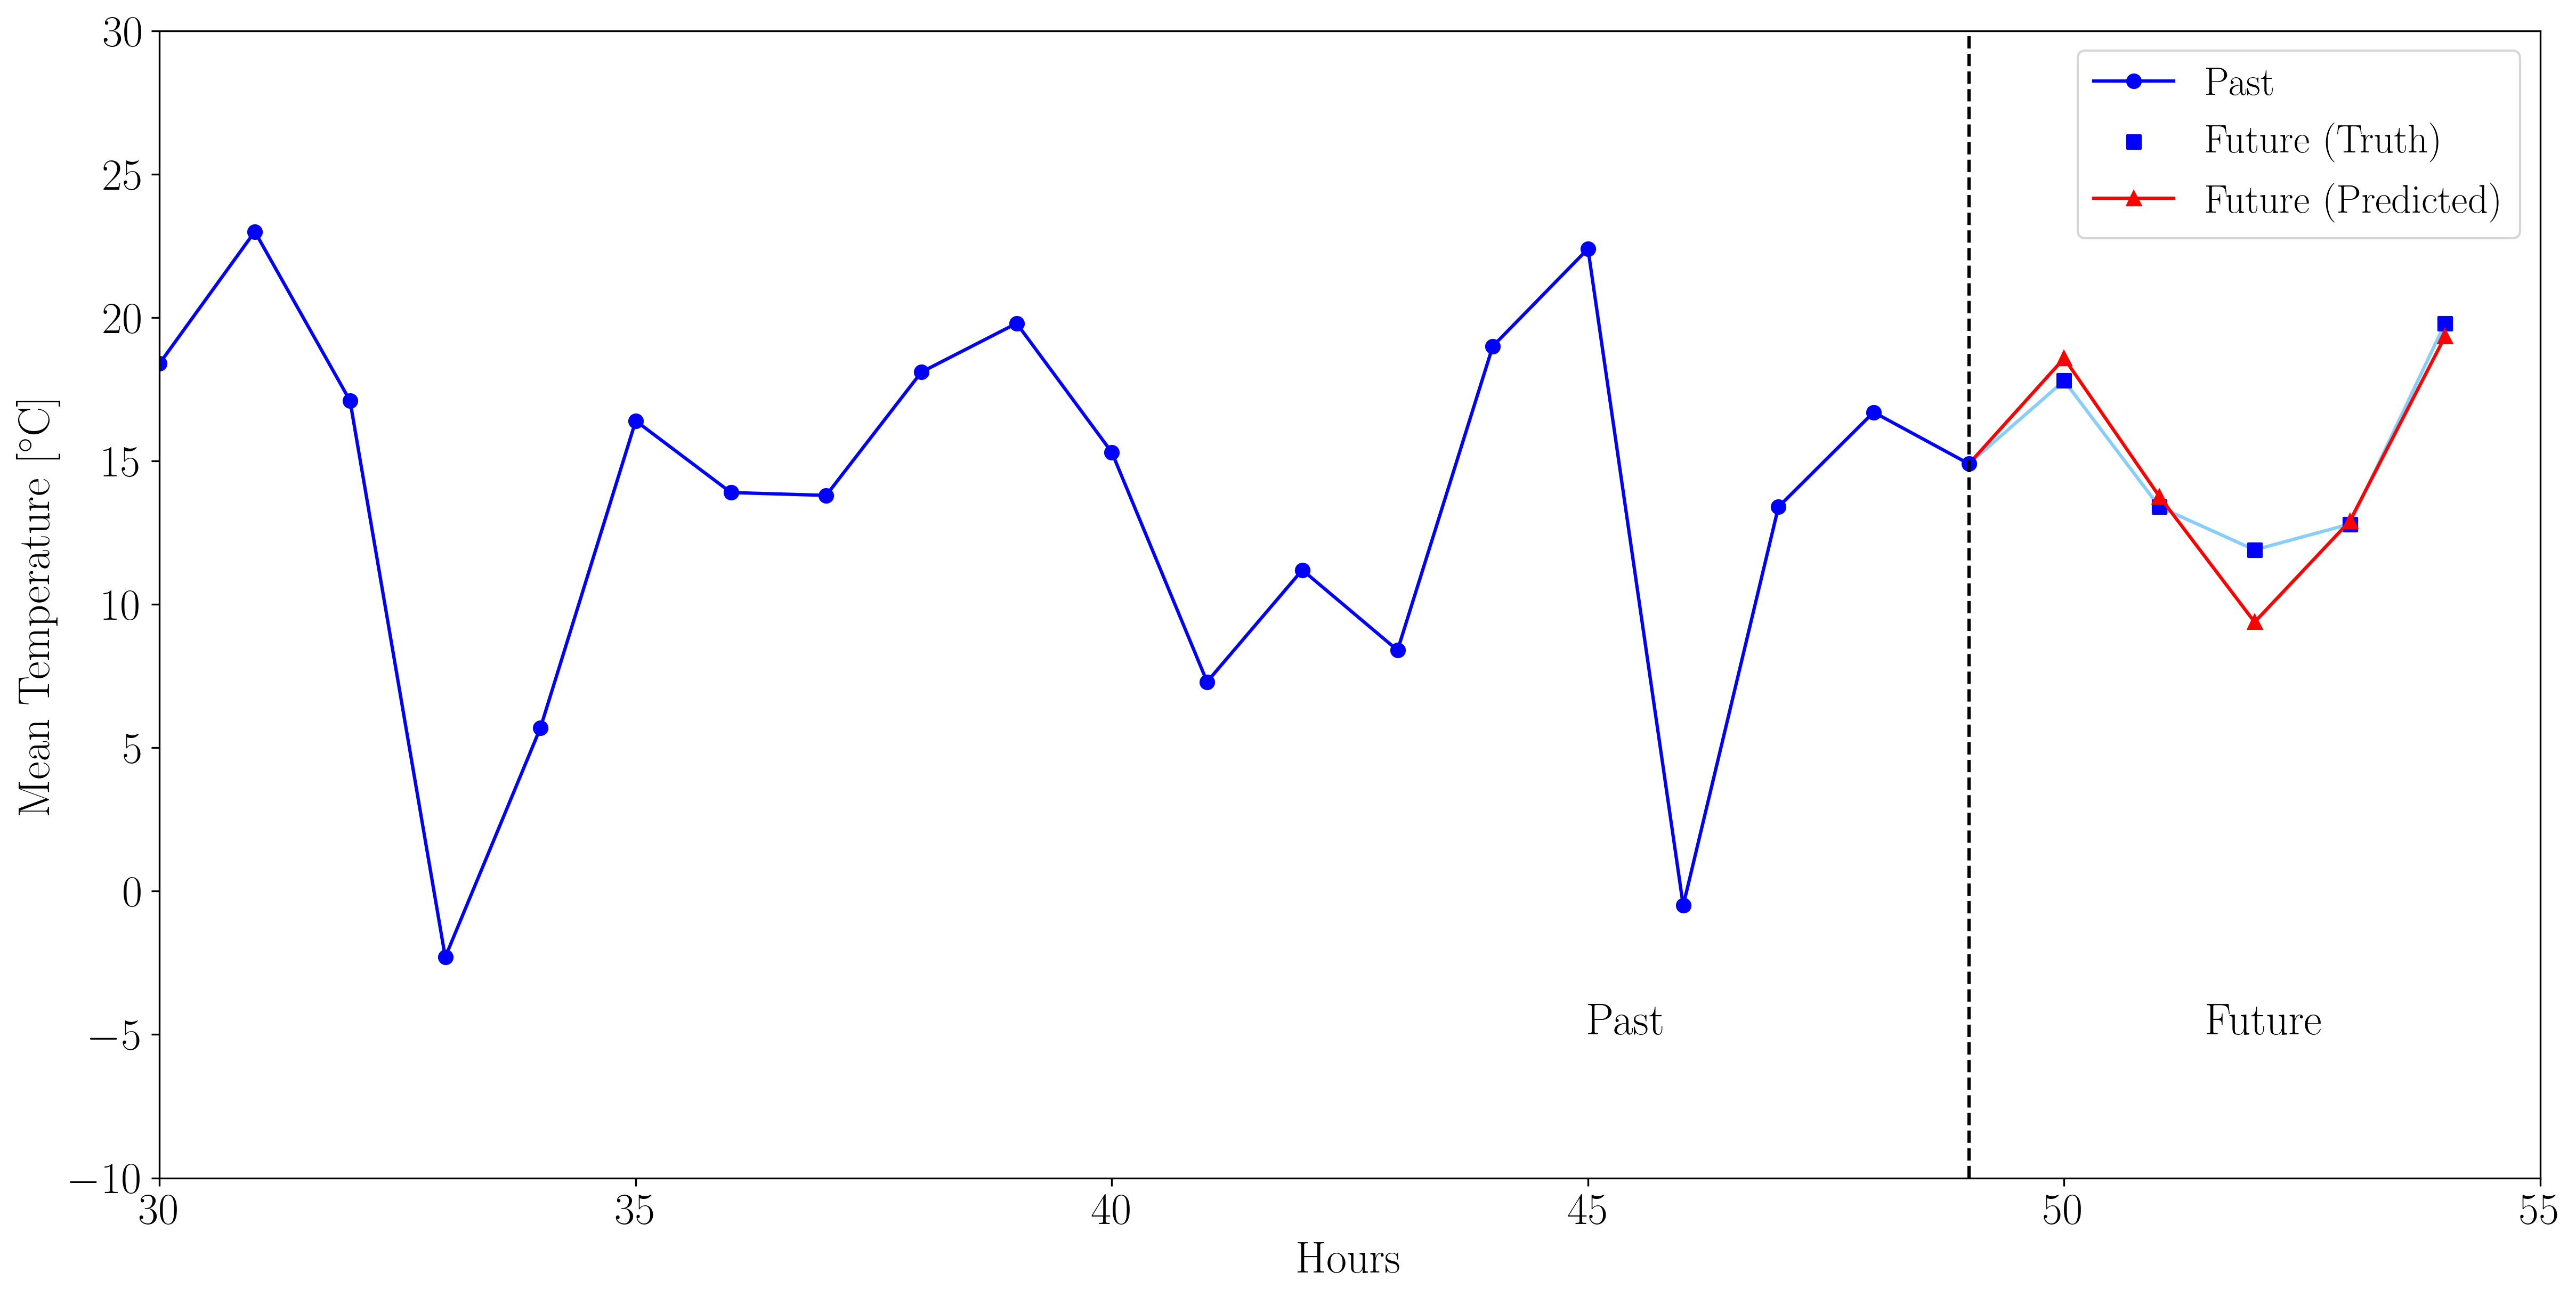

In [81]:
trainscore = math.sqrt(mean_squared_error(tyinv, tpred))
testscore = math.sqrt(mean_squared_error(yinv, pred))
print('Train Score: %.6f RMSE' % (trainscore))
print('Test  Score: %.6f RMSE' % (testscore))

# s = int(len(pred) * 0.01)
s = 1

scaledpred = predr[50:55]
# scaledyinv = yinv[::s]
scaledyinv = yinvr[:55]
scaledtpred = tpred[::s]
scaledtyinv = tyinv[::s]

print(np.mean(np.abs(scaledpred - scaledyinv[50:]) / scaledyinv[50:] * 100))

plt.figure(figsize=(16, 8))
plt.plot(np.arange(50), scaledyinv[:50], label=r'Past', c='b', marker='o')
plt.plot(np.arange(50, 55), scaledyinv[50:], c='lightskyblue')
plt.scatter(np.arange(50, 55), scaledyinv[50:], label=r'Future (Truth)', c='b', marker='s', zorder=10)
plt.plot(np.arange(50, 55), scaledpred, label=r'Future (Predicted)', c='r', marker='^', zorder=10)
plt.plot([49, 50], [scaledyinv[-6], scaledyinv[-5]], c='lightskyblue', zorder=1)
plt.plot([49, 50], [scaledyinv[-6], scaledpred[0]], c='r', zorder=1)
plt.plot([49, 49], [-10, 30], c='k', ls='--')
plt.text(x=45, y=-5, s=r'Past')
plt.text(x=51.5, y=-5, s=r'Future')
plt.legend()
plt.ylim(-10, 30)
plt.xlim(30, 55)
plt.xlabel(r'Hours')
plt.ylabel(r'Mean Temperature [$^{\circ}$C]')
plt.show()

### __Test on Some Recent Data__

In [127]:
v = np.array([12.7, 12.4, 12.0, 11.8, 12.2, 12.5, 12.9, 13.3, 14.1, 15.1])
v.shape

(10,)

In [26]:
testing = data.tail(sequence_length + forecast_horizon)
testingx = testing[:sequence_length]
testingy = testing[sequence_length:]
testingy = testingy['mean_temp']

# xtest = []
# ytest = []

# for t in range(sequence_length, (len(testing)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
#     xtest.append(np.array(data[data.columns][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
#     ytest.append(data['mean_temp'][t+forecast_horizon])
# # put testing data into this format then run it

# xtest = np.array(xtest)
# ytest = np.array(ytest)

# print(xtest.shape, ytest.shape)

testingx = np.array(testingx)
testscale = MinMaxScaler()
testingx = testscale.fit_transform(testingx)
testingx = np.reshape(testingx, (1, len(testingx), len(data.columns)))
print(testingx.shape, testingy.shape)


predictions1 = model.predict(x=testingx)
print(predictions1.shape)

pred = testscale.inverse_transform(predictions1)
# yinv = scalers[4].inverse_transform(testingx.reshape(-1, 1))


(1, 50, 8) (5,)
(1, 1)


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,8)

In [28]:
pred.shape, yinv.shape

((1, 1), (400, 1))

In [29]:
print(pred)

[[1.6141458]]


In [1]:
0.091936**2

0.008452228096